In [1]:
from torch.autograd import Variable

In [2]:
import PIL
from PIL import Image
import numpy as np

In [3]:
from _model import ConvAutoencoder, collect_feature_maps
from _utils import *

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

### Load chosen image 

In [5]:
input_path = '../data/eagle.jpg'

img_pil = Image.open(input_path)
img_pil = crop_image_by_multiplier(img_pil, d=32)

img_np = pil_to_np(img_pil)
img_np.shape

(3, 480, 576)

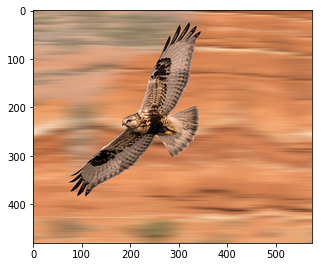

In [6]:
plot_image_grid([img_np], factor=4);

### Load model 

In [7]:
model = ConvAutoencoder()

# apply feature map collection hook
collect_feature_maps(model)

### Define optimization 

In [8]:
learning_rate = 1e-3
mse_loss = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate,
    weight_decay=1e-5)

### Train model for several epochs 

In [9]:
num_iter = 80

In [10]:
model.train()

X = torch.Tensor(img_np).unsqueeze(0)
X = Variable(X)

learning_curve = []
recon_curve = [torch_to_np(X)]

for epoch in range(num_iter):

    X_rec = model(X)  # inference
    
    loss = mse_loss(X_rec, X)
    learning_curve.append(loss)
    
    if epoch % 50 == 0:
        print("epoch:: {}, LOSS = {}".format(epoch + 1, loss))
        if epoch >= 10:
            recon_curve.append(torch_to_np(X_rec))
    
    loss.backward()
    optimizer.step()
    model.zero_grad()

/home/goren/miniconda3/envs/torch/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


epoch:: 1, LOSS = 0.048597391694784164
epoch:: 51, LOSS = 0.014071720652282238


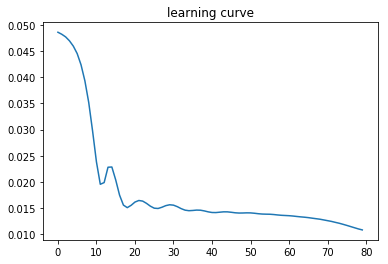

In [11]:
plt.plot(learning_curve);
plt.title('learning curve');

### Visualize reconstruction

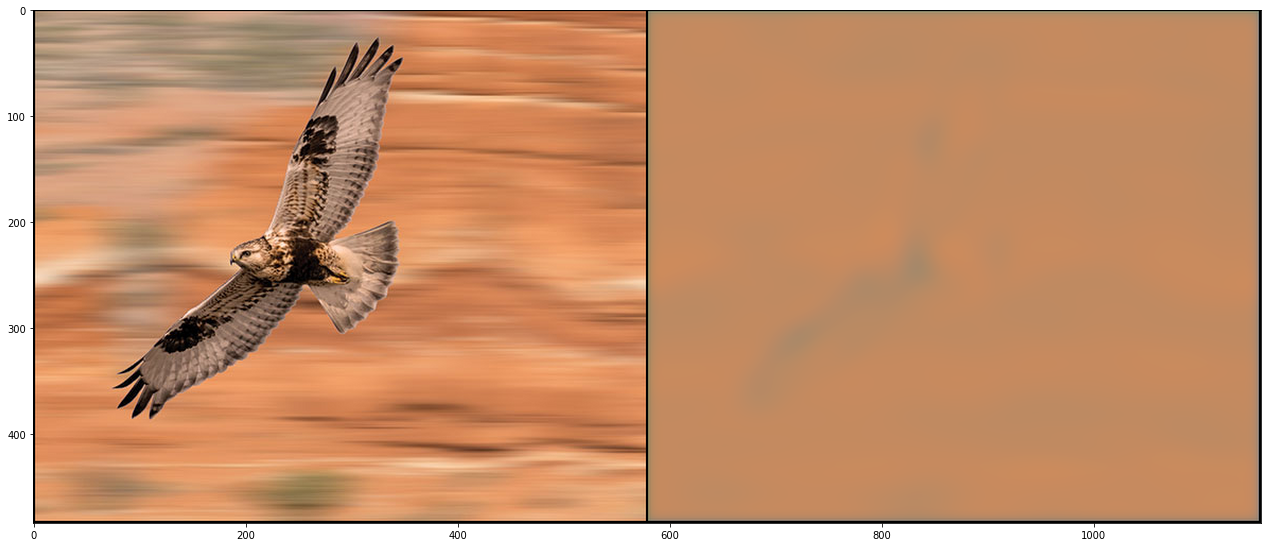

In [12]:
plot_image_grid(recon_curve, factor=20);

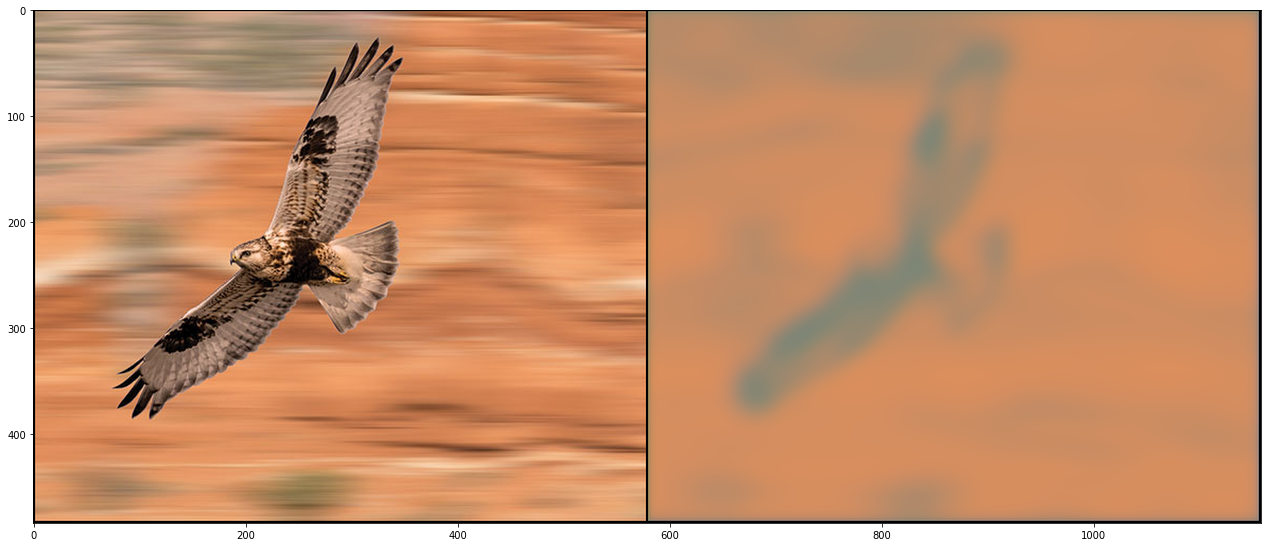

In [13]:
plot_image_grid([torch_to_np(X), torch_to_np(X_rec)], factor=20);

### Visualize feature maps 

In [14]:
feature_maps = model.feature_maps
feature_maps.keys()

odict_keys(['conv2d_1', 'conv2d_4', 'conv2d_7'])

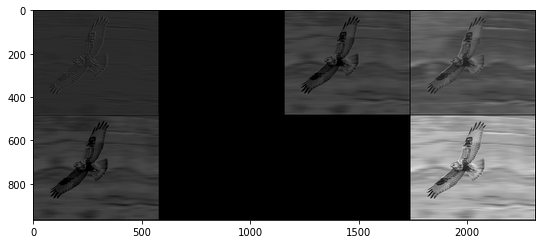

In [15]:
plot_image_grid(feature_maps['conv2d_1'], nrow=4);

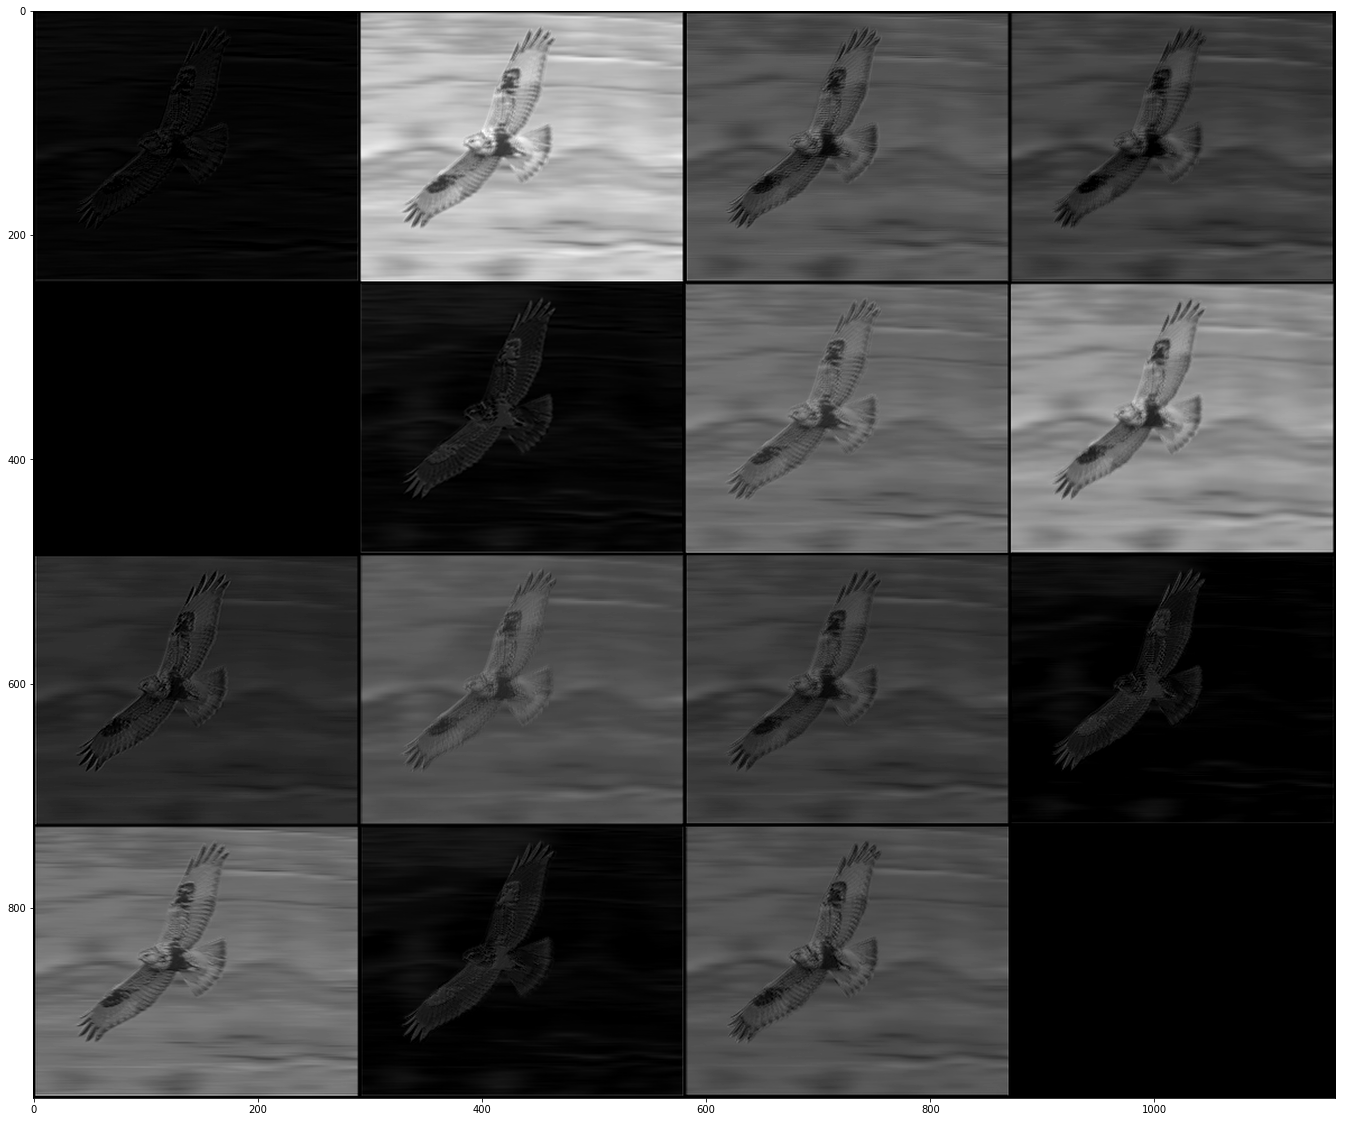

In [16]:
plot_image_grid(feature_maps['conv2d_4'], nrow=4, factor=8);

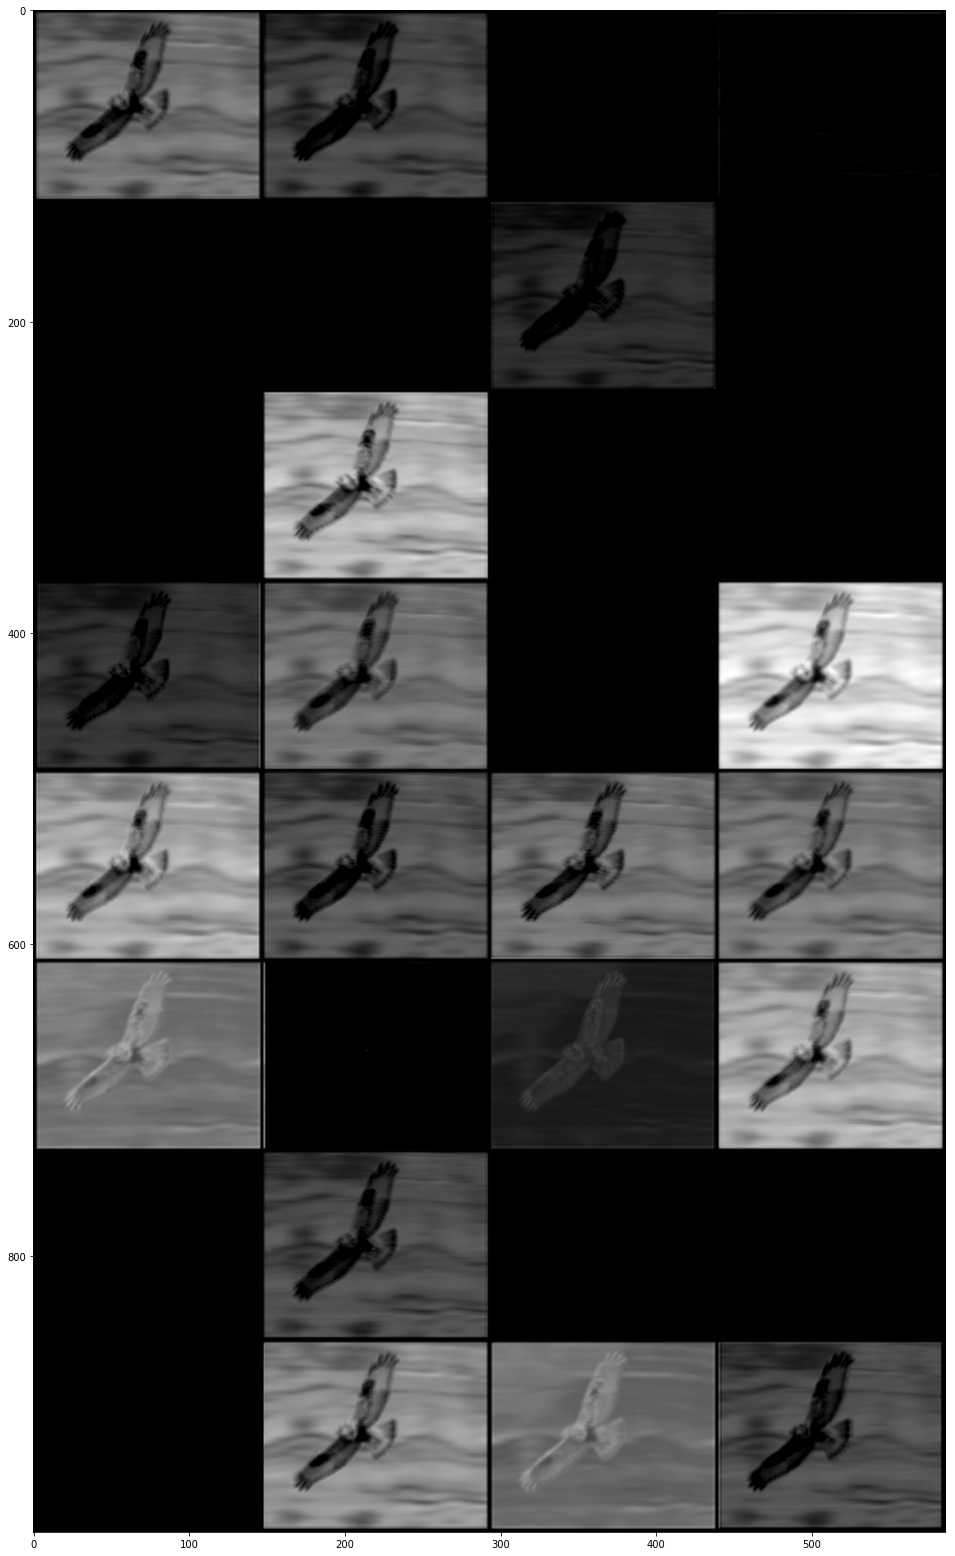

In [17]:
plot_image_grid(feature_maps['conv2d_7'], nrow=4, factor=16);